# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

##### Целевой признак - финальная температура стали. 
##### Метрика - MAE.

#### Часть 1. [Подготовка данных](#part1)
* [1.1. Импорт библиотек.](#part1.1)
* [1.2. Загрузка, изучение и предобработка данных](#part1.2)  
    * [1.2.1 Данные об электродах](#part1.2.1)
    * [1.2.2 Данные о подаче газа](#part1.2.2)
    * [1.2.3 Данные о подаче сыпучих материалов](#part1.2.3)
    * [1.2.4 Данные о подаче сыпучих материалов (время)](#part1.2.4)
    * [1.2.5 Данные о подаче проволоки](#part1.2.5)
    * [1.2.6 Данные о подаче проволоки (время)](#part1.2.6)
    * [1.2.7 Данные о температуре](#part1.2.7)
* [1.3. План работы](#part1.3)
* [1.4 Создание общего датафрейма](#part1.4)
* [1.5 Разбиение данных](#part1.4)
* [1.6 Проблема мультиколлинеарности](#part1.6)

#### Часть 2. [Обучение моделей](#part2)
* [2.1. Линейная регрессия.](#part2.1)
* [2.2. Случайный лес](#part2.2)
* [2.3. SVR.](#part2.3)
* [2.4. Градиентный бустинг](#part2.4)  
* [2.5. Важность признаков](#part2.5)
* [2.6. Анализ моделей](#part2.6)


* [Общий вывод](#part3)
* [Отчет по решению](#part4)


<a id='part1'></a>
# 1. Подготовка данных
<a id='part1.1'></a>
## 1.1 Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import time
import numpy as np

<a id='part1.2'></a>
## 1.2 Загрузка, изучение и предобработка данных
<a id='part1.2.1'></a>
### 1.2.1 Данные об электродах

Загрузим и изучим первую таблицу.

In [2]:
try: 
    data_arc = pd.read_csv('datasets/final_steel/data_arc.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()
data_arc.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Пропуски отсутствуют. Столбцы с временами имеют тип object. Для удобства следует переименовать столбцы, перевести столбцы с временами начала и конца нагрева в формат datetime и заменить их на один столбец с длительностью нагрева.

Как известно из курса физики, полезную работу (в нашем случае нагрев), совершает только активная мощность. Поэтому столбец с значениями реактивной мощности можно смело удалять.

In [3]:
for name in ['Начало нагрева дугой','Конец нагрева дугой']:
    data_arc[name] =  pd.to_datetime(data_arc[name], format='%Y-%m-%d %H:%M:%S')
data_arc['Длительность нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
data_arc = data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой', 'Реактивная мощность'], axis=1)
data_arc = data_arc.rename(columns={"Активная мощность": "act_power", 
                                "Длительность нагрева" : "heat_time"})
data_arc.head(5)

,key,act_power,heat_time
0,1,0.976059,228
1,1,0.805607,185
2,1,0.744363,172
3,1,1.659363,365
4,1,0.692755,148


Модель должна предсказывать конечную температуру. Поэтому не будем рассматривать процесс по итерациям нагрева, а наоборот, сгруппируем таблицу, усредняя мощность и складывая время нагрева. Также добавим в таблицу количество итераций.

In [4]:
data_arc = data_arc.groupby('key').agg({'act_power': ['mean','count'], 'heat_time' : 'sum'}).reset_index()
data_arc.columns = data_arc.columns.droplevel(level=1)
data_arc.columns = ['key','act_power','n_iter','heat_time']
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        3214 non-null   int64  
 1   act_power  3214 non-null   float64
 2   n_iter     3214 non-null   int64  
 3   heat_time  3214 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 100.6 KB


Text(0.5, 0.98, 'Распределения признаков в данных об электродах')

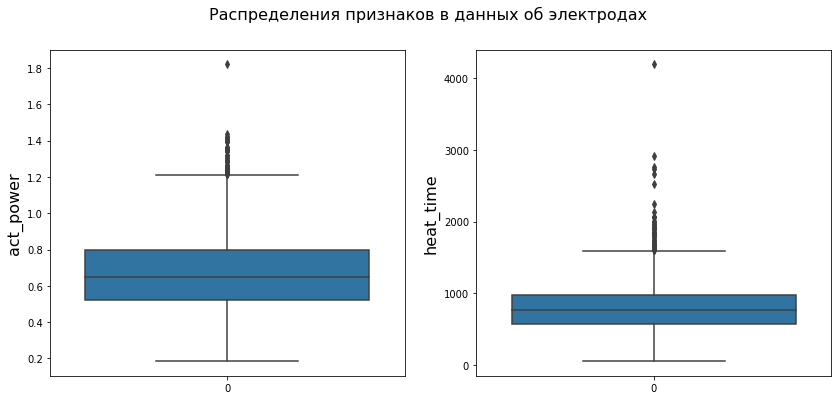

In [5]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
row=0
for name in ['act_power','heat_time']:

    
    ax[row].set(ylabel=name, xlabel='')
    ax[row].yaxis.get_label().set_fontsize(16)

    #col+=1
    sns.boxplot(ax=ax[row], data=data_arc[name])
    
    row+=1
plt.suptitle('Распределения признаков в данных об электродах', fontsize=16)

Видны явные выбросы в данных. Можно удалить значения активной мощности больше 2, реактивной мощности больше -500 и времени нагрева больше 500.
После этого заново построим ящики с усами и добавим к ним гистограммы.

Text(0.5, 0.98, 'Распределения признаков в данных об электродах')

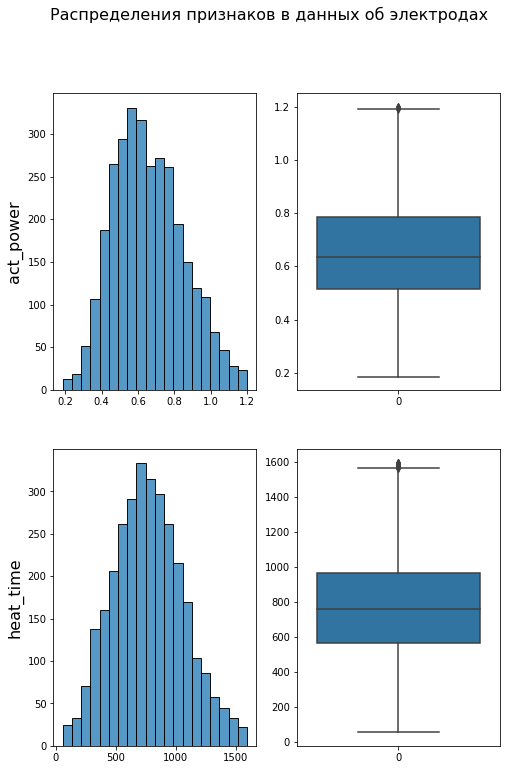

In [6]:
data_arc = data_arc[(data_arc['act_power']<=1.2) & (data_arc['heat_time']<1600)]

fig, ax = plt.subplots(2,2,figsize=(8,12))
row=0

for name in ['act_power','heat_time']:
    col=0
    sns.histplot(ax=ax[row,col], data=data_arc[name], bins=20)
    
    ax[row,col].set(ylabel=name, xlabel='')
    ax[row,col].yaxis.get_label().set_fontsize(16)

    col+=1
    sns.boxplot(ax=ax[row,col], data=data_arc[name])
    
    row+=1
plt.suptitle('Распределения признаков в данных об электродах', fontsize=16)

In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3120 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        3120 non-null   int64  
 1   act_power  3120 non-null   float64
 2   n_iter     3120 non-null   int64  
 3   heat_time  3120 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 201.9 KB


Таблица сгруппирована по партиям. Удален столбец с реактивной энергией, усреднена мощность, времена начала и конца нагрева заменены на длительность нагрева и просуммированы.

Было удалено 96 партий с значениями-выбросами.

<a id='part1.2.2'></a>
### 1.2.2 Данные о подаче газа

Загрузим и изучим вторую таблицу.

In [8]:
try:
    data_gas = pd.read_csv('datasets/final_steel/data_gas.csv')
except:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Переименуем столбцы, построим гистограмму и ящик с усами.

Text(0.5, 0.98, 'Распределения признаков в данных газе')

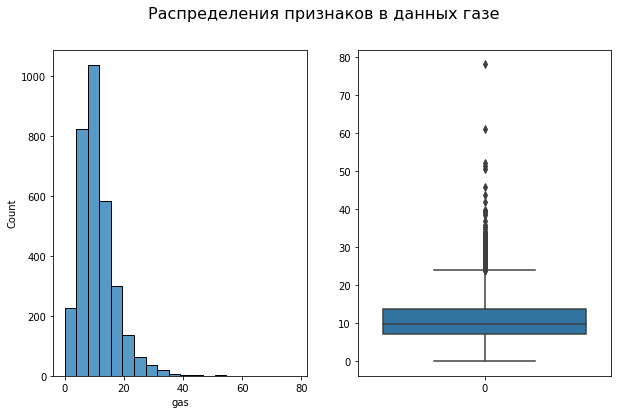

In [9]:
data_gas.columns = ['key','gas']

fig, ax = plt.subplots(1,2,figsize=(10,6))

sns.histplot(ax=ax[0], data=data_gas['gas'], bins=20)
    
sns.boxplot(ax=ax[1], data=data_gas['gas'])
    
plt.suptitle('Распределения признаков в данных газе', fontsize=16)

Видны выбросы в данных. Удалим партии, где газа добавляли больше 30.

In [10]:
data_gas = data_gas[data_gas['gas'] < 30]

<a id='part1.2.3'></a>
### 1.2.3 Данные о подаче сыпучих материалов

Загрузим и изучим третью таблицу.

In [11]:
try:
    data_bulk = pd.read_csv('datasets/final_steel/data_bulk.csv')
except: 
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()
data_bulk.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Построим гистограммы для каждой примеси, чтобы найти выбросы.


Text(0.5, 0.98, 'Распределения кол-ва добавленной смеси в данных о сухих примесях')

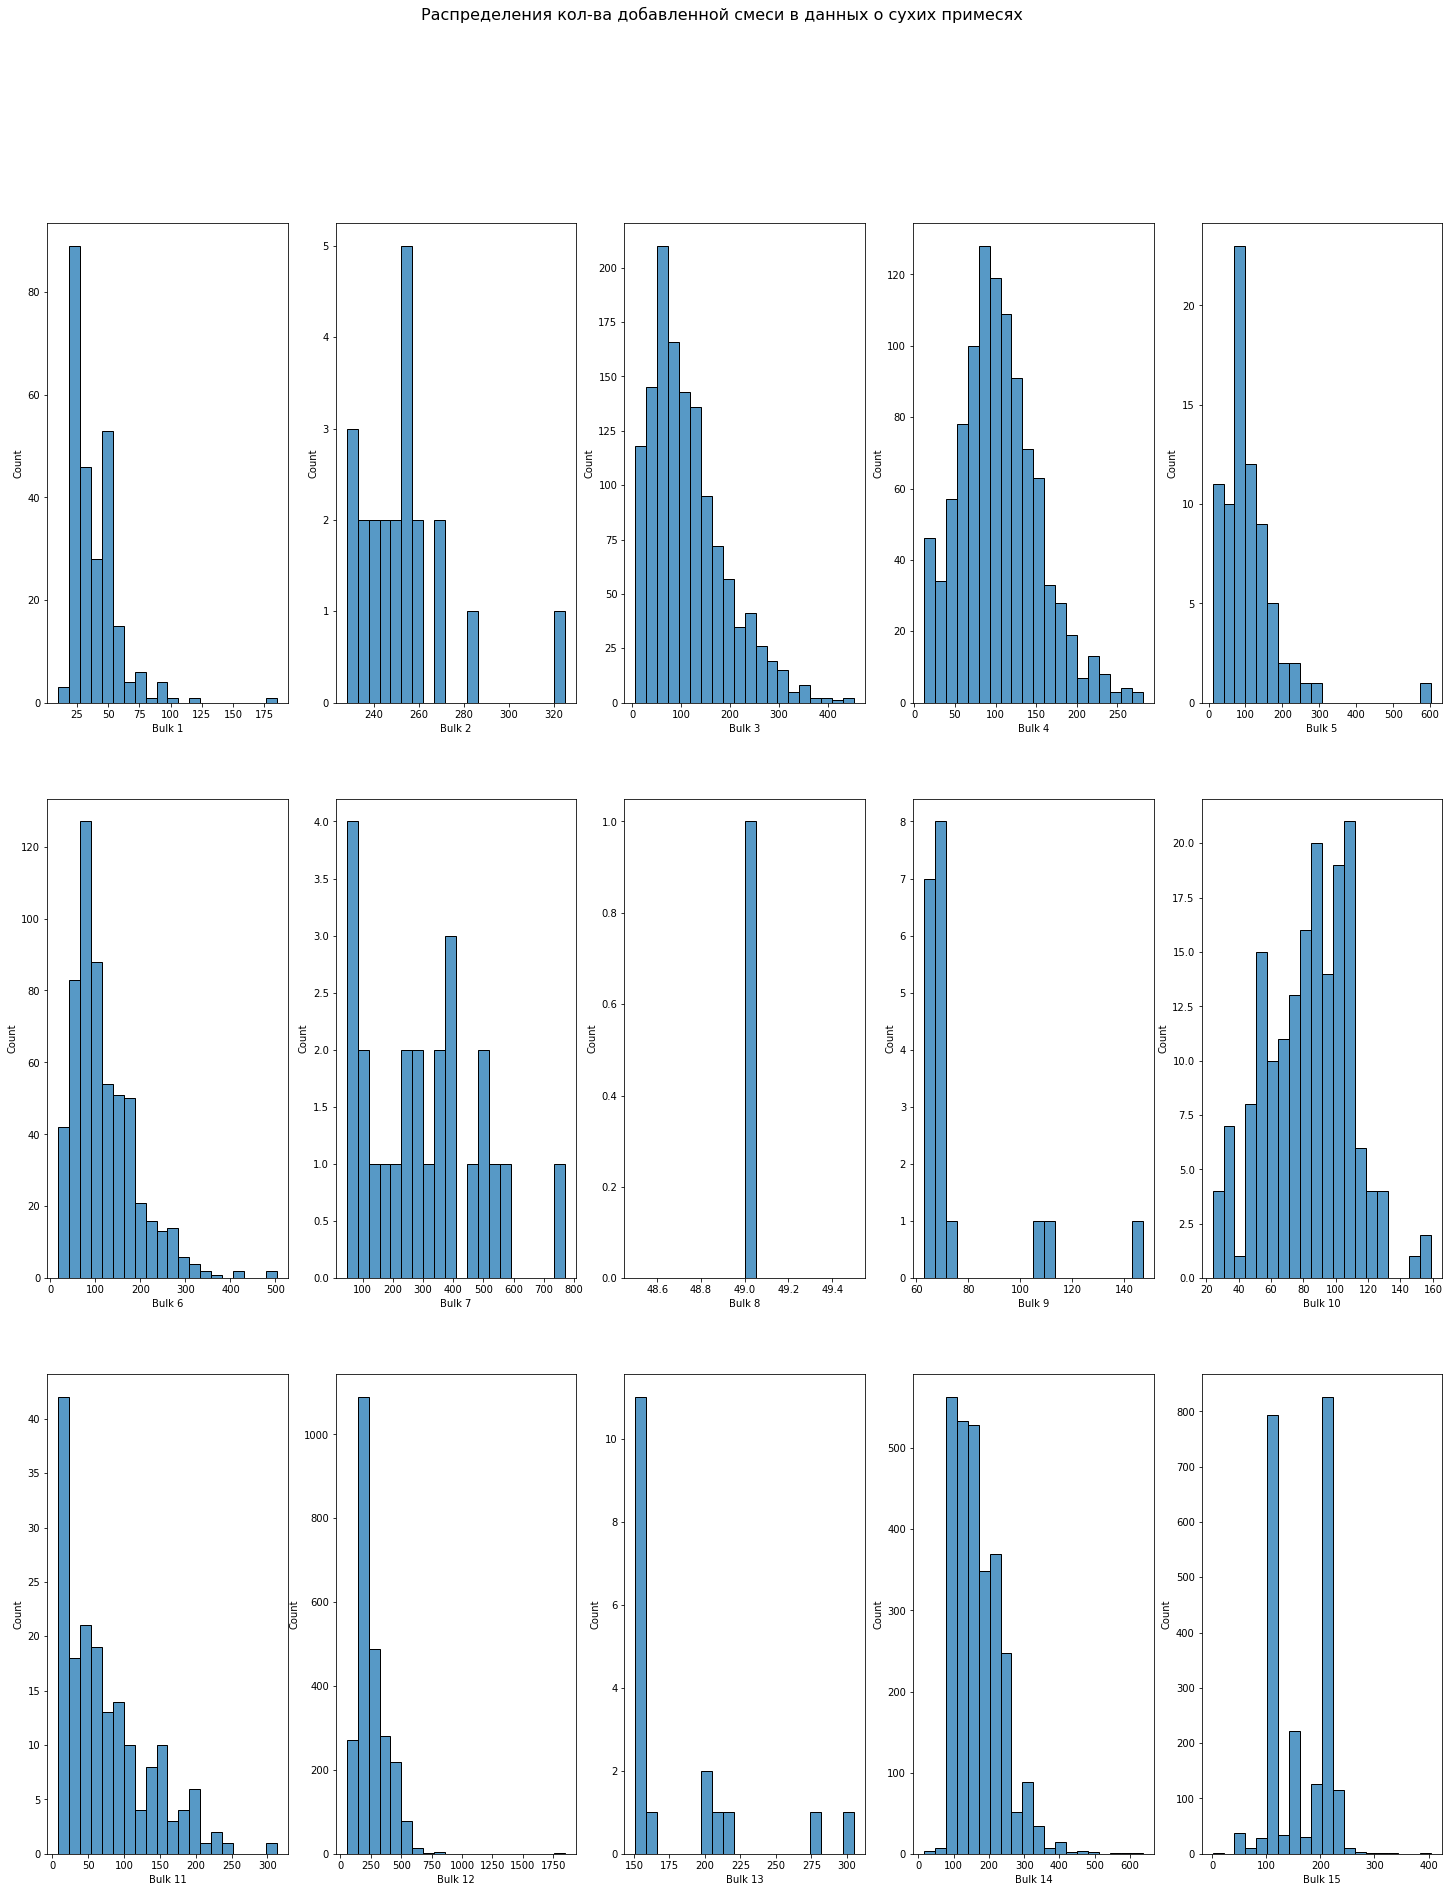

In [12]:
fig, ax = plt.subplots(3,5,figsize=(25,30))
row=0
col=0
for name in data_bulk.columns:
    
            
    if name != 'key':
        sns.histplot(ax=ax[row,col], data=data_bulk[name], bins=20)
        
        col+=1
        if col == 5:
            row+=1
            col=0    
    
plt.suptitle('Распределения кол-ва добавленной смеси в данных о сухих примесях', fontsize=16)

Как видно из гистограмм, в некоторых партиях примесей добавляли больше, чем обычно. Если модель будет ненадлежащего качества, то эти данные можно будет удалить.
В таблице присутствуют отсутствующие значения. Это говорит о том, что в каждую партию некоторые примеси не добавлялись.  
Заменим NaN нулями.

In [13]:
data_bulk = data_bulk.fillna(0)

<a id='part1.2.4'></a>
### 1.2.4 Данные о подаче сыпучих материалов (время)

Загрузим и изучим четвертую таблицу.

In [14]:
try: 
    data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time.csv')
except:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


В таблице видны пропуски (материалы не подавались), время имеет тип object.
Заменим пропуски нулями и изменим тип данных.

In [15]:
for name in data_bulk_time.columns:
    if name != 'key':
        data_bulk_time[name] =  pd.to_datetime(data_bulk_time[name], format='%Y-%m-%d %H:%M:%S')
data_bulk_time = data_bulk_time.fillna(0)
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,2019-05-03 11:21:30,0,0,0,0,0,0,0,2019-05-03 11:03:52,0,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,0,0,0,2019-05-03 11:46:38,0,0,0,0,0,0,0,2019-05-03 11:40:20,0,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,0,0,0,2019-05-03 12:31:06,0,0,0,0,0,0,0,2019-05-03 12:09:40,0,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,0,0,0,2019-05-03 12:48:43,0,0,0,0,0,0,0,2019-05-03 12:41:24,0,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,0,0,0,2019-05-03 13:18:50,0,0,0,0,0,0,0,2019-05-03 13:12:56,0,2019-05-03 13:12:56,2019-05-03 13:12:56


<a id='part1.2.5'></a>
### 1.2.5 Данные о подаче проволоки

Загрузим и изучим пятую таблицу.

In [16]:
try:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
except:
    data_wire = pd.read_csv('datasets/final_steel/data_wire.csv')
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим гистограммы

Text(0.5, 0.98, 'Распределения кол-ва добавленной проволоки')

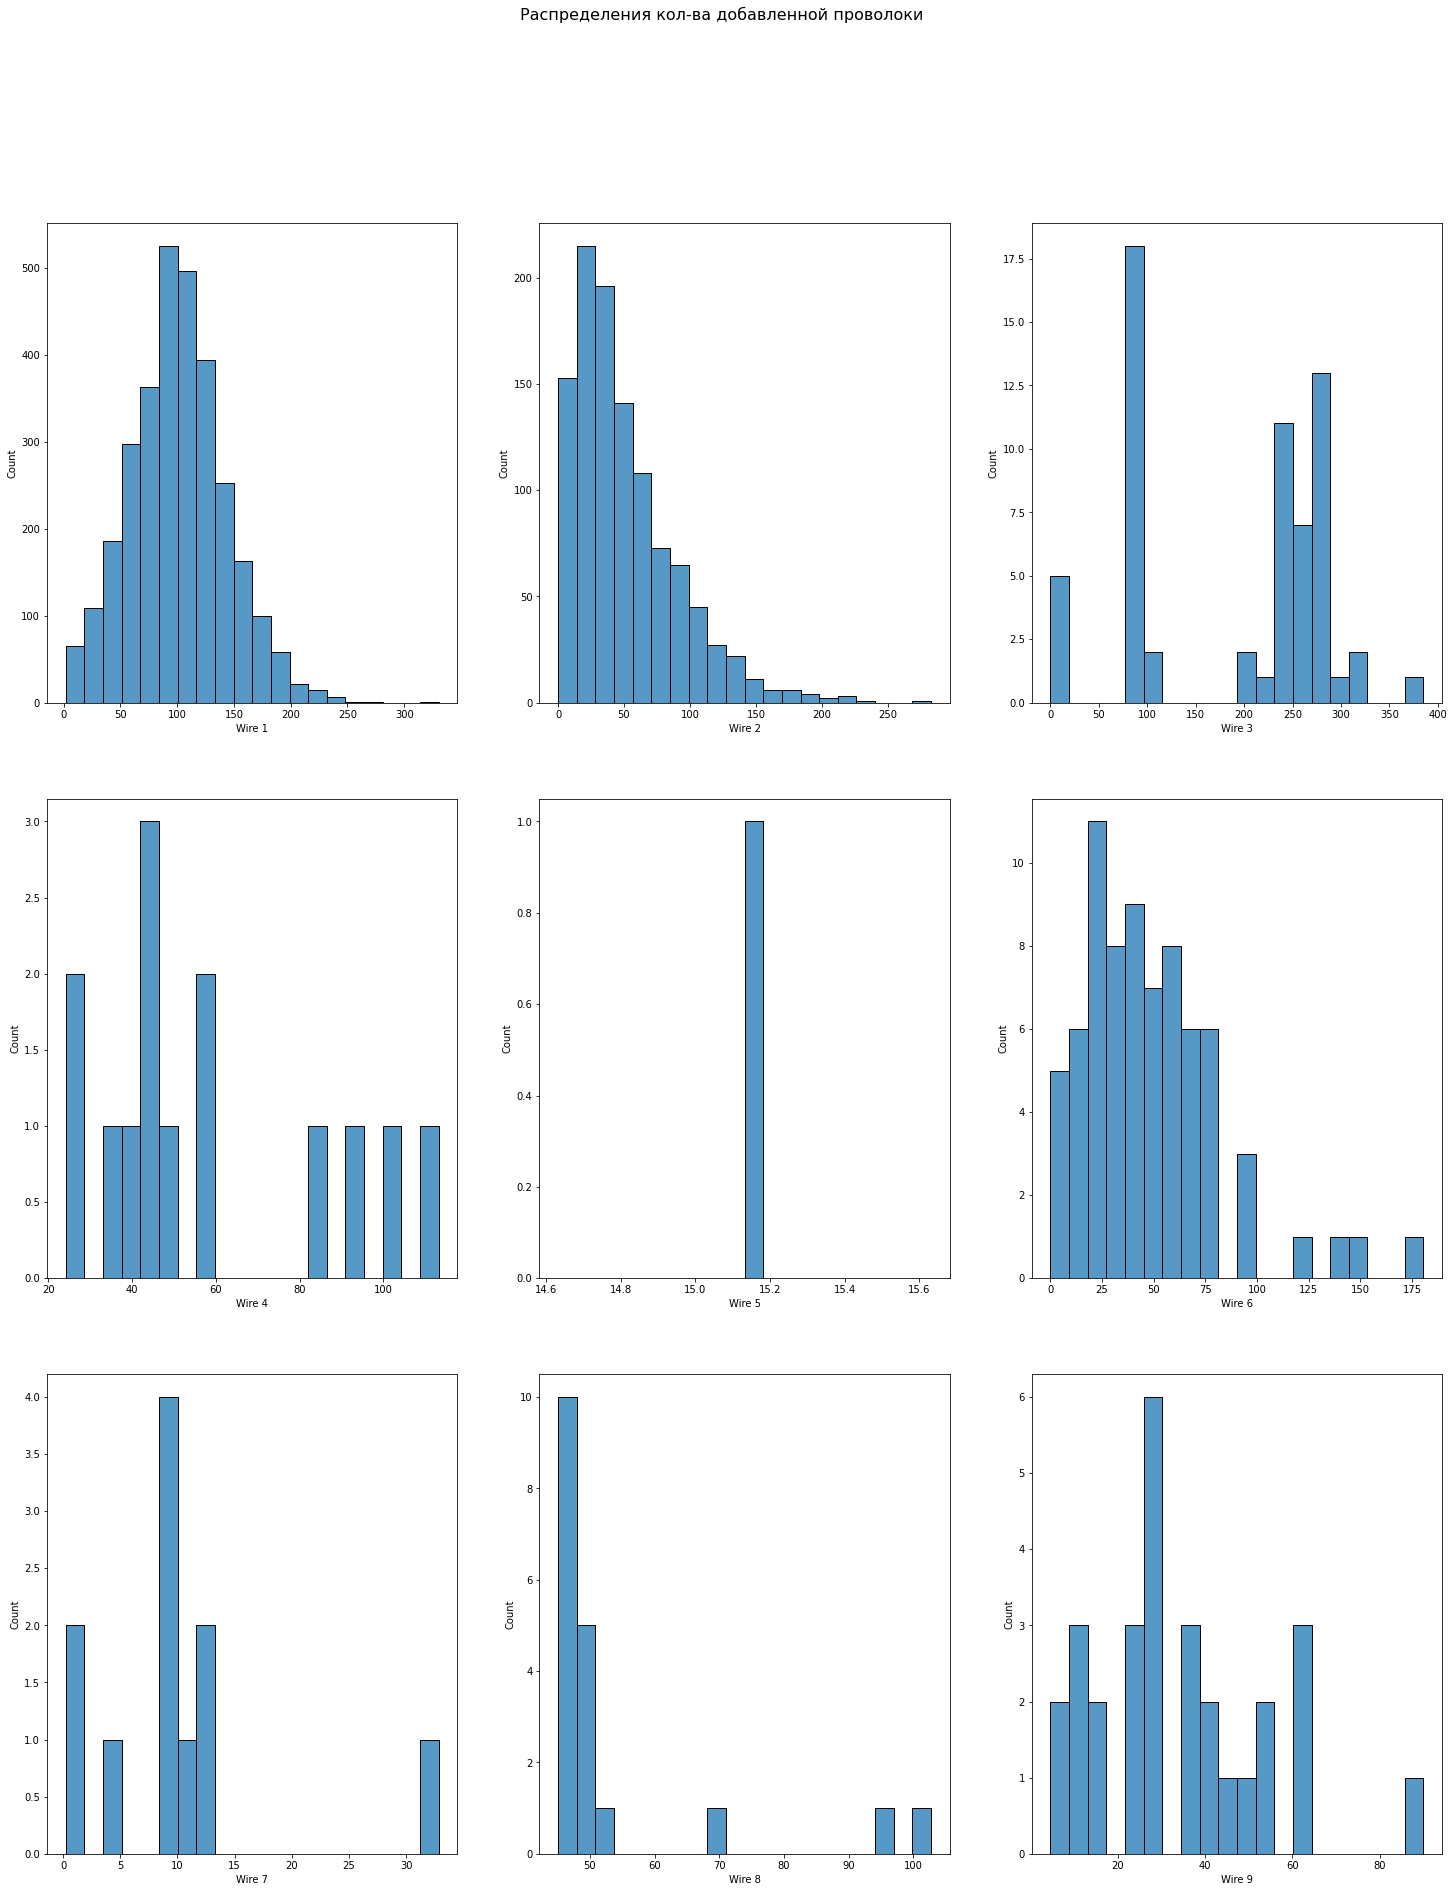

In [17]:
fig, ax = plt.subplots(3,3,figsize=(25,30))
row=0
col=0
for name in data_wire.columns:
    
            
    if name != 'key':
        sns.histplot(ax=ax[row,col], data=data_wire[name], bins=20)
        
        col+=1
        if col == 3:
            row+=1
            col=0    
    
plt.suptitle('Распределения кол-ва добавленной проволоки', fontsize=16)

Аномальных значений нет, поэтому поступаем также, как и с данными по примесям. Заменяем отсутствующие значения нулями и считаем предобработку данной таблицы завершенной.

In [18]:
data_wire = data_wire.fillna(0)

<a id='part1.2.6'></a>
### 1.2.6 Данные о подаче проволоки (время)

Загрузим и изучим шестую таблицу.

In [19]:
try:
    data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time.csv')
except:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.info()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Такая же картина, как и в данных о сыпучих материалах. Изменим тип данных и заполним пропуски нулями.

In [20]:
for name in data_wire_time.columns:
    if name != 'key':
        data_wire_time[name] =  pd.to_datetime(data_wire_time[name], format='%Y-%m-%d %H:%M:%S')
data_wire_time = data_wire_time.fillna(0)
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:46:10,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:13:47,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:48:05,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,0,0,0,0,0,0,0


<a id='part1.2.7'></a>
### 1.2.7 Данные о температуре

Загрузим и изучим седьмую таблицу.

In [21]:
try:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
except:
    data_temp = pd.read_csv('datasets/final_steel/data_temp.csv')
data_temp.info()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Для построения модели мы будем использовать начальную и конечную температуры. Поэтому, удаляя пропуски, необходимо проверять, не является ли удалеяемое значение конечным. Иначе придется удалять данные о всей партии.

Выберем из таблицы все значения начальных и конечных температур и создадим из них новый датафрейм.


In [22]:
data_temps = pd.DataFrame(columns=['key','temp_first','temp_last'])
i=0
for key in data_temp['key'].unique():
    temp_first = data_temp[data_temp['key']==key].iloc[0][2]
    temp_last = data_temp[data_temp['key']==key].iloc[-1][2]
    data_temps.loc[i] = [key, temp_first, temp_last]
    i+=1
data_temps

,key,temp_first,temp_last
0,1.0,1571.0,1613.0
1,2.0,1581.0,1602.0
2,3.0,1596.0,1599.0
3,4.0,1601.0,1625.0
4,5.0,1576.0,1602.0
...,...,...,...
3211,3237.0,1569.0,NaN
3212,3238.0,1584.0,NaN
3213,3239.0,1598.0,NaN
3214,3240.0,1617.0,NaN


Удалим из получившегося датафрейма все строки с пропусками

In [23]:
data_temps = data_temps.dropna()
data_temps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2477 non-null   float64
 1   temp_first  2477 non-null   float64
 2   temp_last   2477 non-null   float64
dtypes: float64(3)
memory usage: 77.4 KB


В результате из исходной таблицы был получен новый датафрейм с значениями номера партии, начальной и конечной температуры партии.

<a id='part1.3'></a>
## 1.3 План работы


- [x]  Данные загружены
- [ ]  Выполнена предобработка данных
    - [x]  Удалены пропуски и выбросы, изменены типы данных
    - [x]  Добавлены новые признаки
    - [x]  Все таблицы сведены в один общий датафрейм с призанками
    - [x]  Данные разделены на тренировочную и тестовую выборки
- [x]  Построена модель
    - [x]  Обучено несколько моделей
    - [x]  Выбраны лучшие гиперпараметры
    - [x]  Предсказано МАЕ
    - [x]  Модели проанализированы    
    - [x]  Выбрана лучшая модель    


<a id='part1.4'></a>
## 1.4 Создание общего датафрейма

Данные о времени подачи сыпучих материалов и проволоки пока использовать в модели не будем.  
Оставшиеся таблицы объединим в одну.

In [24]:
data_to_merge = [data_arc, data_gas, data_bulk, data_wire, data_temps]
data_merged = reduce(lambda  left,right: pd.merge(left,right,on=['key'],
                                            how='outer'), data_to_merge)

Удалим из получившегося датафрейма пропуски и столбец 'key', так как для обучения он не нужен.

In [25]:
data_merged = data_merged.dropna()
data_merged = data_merged.drop(['key'], axis=1)
data_merged.info()
data_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 0 to 2397
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   act_power   2233 non-null   float64
 1   n_iter      2233 non-null   float64
 2   heat_time   2233 non-null   float64
 3   gas         2233 non-null   float64
 4   Bulk 1      2233 non-null   float64
 5   Bulk 2      2233 non-null   float64
 6   Bulk 3      2233 non-null   float64
 7   Bulk 4      2233 non-null   float64
 8   Bulk 5      2233 non-null   float64
 9   Bulk 6      2233 non-null   float64
 10  Bulk 7      2233 non-null   float64
 11  Bulk 8      2233 non-null   float64
 12  Bulk 9      2233 non-null   float64
 13  Bulk 10     2233 non-null   float64
 14  Bulk 11     2233 non-null   float64
 15  Bulk 12     2233 non-null   float64
 16  Bulk 13     2233 non-null   float64
 17  Bulk 14     2233 non-null   float64
 18  Bulk 15     2233 non-null   float64
 19  Wire 1      2233 non-null  

,act_power,n_iter,heat_time,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,temp_first,temp_last
0,0.975629,5.0,1098.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0
1,0.763150,4.0,811.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0
2,0.505176,5.0,655.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0
3,0.802313,4.0,741.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1625.0
4,0.836793,4.0,869.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1602.0


In [26]:
data_merged.tail(3)

,act_power,n_iter,heat_time,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,temp_first,temp_last
2395,0.737460,3.0,569.0,6.271699,0.0,0.0,0.0,85.0,0.0,0.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1589.0
2396,0.681745,5.0,750.0,14.953657,0.0,0.0,90.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1591.0,1594.0
2397,1.024608,4.0,883.0,11.336151,0.0,0.0,47.0,0.0,0.0,0.0,...,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1569.0,1603.0


<a id='part1.5'></a>
## 1.5 Разбиение данных

Разобьем данные на обучающую и тестовую выборки

In [27]:
y = data_merged['temp_last']
X = data_merged.drop('temp_last', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=1)

print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тест выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (1674, 29) (1674,)
Размер тест выборки: (559, 29) (559,)


<a id='part1.6'></a>
## 1.6 Проблема мультиколлинеарности

Найдем все сильно коррелирующие между собой признаки (с коэффициентом корреляции больше 0.8)

In [28]:
for index in X.corr().index:
    for column in X.corr().columns:
        if X.corr()[index][column] >= 0.8 and X.corr()[index][column] != 1:
            print(index,column)

Bulk 9 Wire 8
Wire 8 Bulk 9


Удалим один из признаков в коррелирующих между собой парах

In [29]:
X = X.drop(['Bulk 9'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=1)

print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тест выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (1674, 28) (1674,)
Размер тест выборки: (559, 28) (559,)


## Вывод

Данные обработаны и подготовлены.  
Удалены пропуски, изменены типы данных, удалены ненужные признаки.  
Добавлены новые признаки, все датафреймы сведены в один.  
Данные разбиты на обучающую и тестовую выборки.  
Удалены признаки, сильно коррелирующие с другими признаками.

<a id='part2'></a>

# 2. Обучение моделей
<a id='part2.1'></a>

Обучим полученный датасет на разных моделях и попытаемся получить наилучший МАЕ.

## 2.1 Линейная регрессия

Сначала попробуем воспользоваться обычными моделями линейной регрессии

In [30]:
for model in [LinearRegression(), Ridge(), Lasso(), ElasticNet()]:
    #обучение
    start_time = time.time()
    model.fit(X_train, y_train)
    time_to_fit = time.time() - start_time
    #предсказание
    start_time = time.time()
    predicted = model.predict(X_test)
    time_to_predict = time.time() - start_time
    
    print(str(model).replace("()",""))
    print('MAE: {:.2f}'.format(mean_absolute_error(y_test,predicted)))
    print('Время обучения: {:.3f}'.format(time_to_fit))
    print('Время предсказания: {:.3f}\n'.format(time_to_predict))

LinearRegression
MAE: 6.09
Время обучения: 0.004
Время предсказания: 0.001

Ridge
MAE: 6.09
Время обучения: 0.002
Время предсказания: 0.001

Lasso
MAE: 6.22
Время обучения: 0.002
Время предсказания: 0.001

ElasticNet
MAE: 6.20
Время обучения: 0.002
Время предсказания: 0.001



MAE везде больше 6, время обучения и предсказания - тысячные доли секунды.

<a id='part2.2'></a>

## 2.2 Случайный лес

Теперь попробуем обучить модель случайного леса, воспользовавшись методом GridSearch для определения оптимальных гиперпараметров.

In [31]:
%%script false --no-raise-error
#пропуск выполнения ячейки

scorer = make_scorer(mean_absolute_error, greater_is_better=False)


model_rf= RandomForestRegressor(random_state=1)

model_params = {
 
    'max_depth': [i for i in range(1,15)],
    'min_samples_split' : [i for i in range(2,15)],
    'min_samples_leaf' : [i for i in range(1,10)],
    'n_estimators' : [i for i in range(20,160,20)]
}

rs_gs = GridSearchCV(model_rf, model_params, scoring=scorer, cv=3, n_jobs=-1)

search_rs_gs = rs_gs.fit(X_train,y_train)
print('Лучшие гиперпараметры:')
print(search_rs_gs.best_estimator_)
print('Лучший MAE:')
print(search_rs_gs.best_score_)

Couldn't find program: 'false'


##### Вывод ячейки
Лучшие гиперпараметры:  
RandomForestRegressor(max_depth=12, min_samples_split=8, random_state=1)  
Лучший MAE:  
-6.134345144140016  

Используем полученные гиперпараметры для обучения модели.

In [32]:
model_rf = RandomForestRegressor(random_state=1,max_depth=12, min_samples_split=8)# min_samples_leaf=3, min_samples_split=5, n_estimators=70)
#обучение
start_time = time.time()
model_rf.fit(X_train, y_train)
time_to_fit = time.time() - start_time
#предсказание
start_time = time.time()
predicted = model_rf.predict(X_test)
time_to_predict = time.time() - start_time

print('RandomForestRegressor')
print('MAE: {:.2f}'.format(mean_absolute_error(y_test,predicted)))
print('Время обучения: {:.3f}'.format(time_to_fit))
print('Время предсказания: {:.3f}\n'.format(time_to_predict))

RandomForestRegressor
MAE: 5.94
Время обучения: 0.661
Время предсказания: 0.010



Требуемый МАЕ достигнут, но можно попробовать еще несколько моделей.

<a id='part2.3'></a>

## 2.3 SVR

Третьей моделью будет регрессия опорных векторов. Также найдем оптимальные гиперпараметры с помощью GridSearchCV.

In [33]:
%%script false --no-raise-error
#пропуск выполнения ячейки

model_svr = SVR(kernel='rbf')
model_params = {
     'C': [0.1,1,100,900,1000,1100],
     'epsilon': [0.1,1.5,1,3,5,10],
}

gsc = GridSearchCV(model_svr, model_params, scoring=scorer,cv=3, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)

print('Лучшие гиперпараметры:')
print(grid_result.best_estimator_)
print('Лучший MAE:')
print(grid_result.best_score_)

Couldn't find program: 'false'


##### Вывод ячейки
Лучшие гиперпараметры:  
SVR(C=1100, epsilon=5)  
Лучший MAE:  
-6.29633028087844  

Обучим модель

In [34]:
model_svr = SVR(epsilon=1,C=1000)
#обучение
start_time = time.time()
model_svr.fit(X_train, y_train)
time_to_fit = time.time() - start_time
#предсказание
start_time = time.time()
predicted = model_svr.predict(X_test)
time_to_predict = time.time() - start_time

print('SVR')
print('MAE: {:.2f}'.format(mean_absolute_error(y_test,predicted)))
print('Время обучения: {:.3f}'.format(time_to_fit))
print('Время предсказания: {:.3f}\n'.format(time_to_predict))

SVR
MAE: 5.99
Время обучения: 0.159
Время предсказания: 0.021



<a id='part2.4'></a>

## 2.4 Градиентный бустинг

В качестве четвертой модели используем градиентный бустинг. 

In [35]:
%%script false --no-raise-error
#пропуск выполнения ячейки

cat = CatBoostRegressor(loss_function='MAE',iterations=2000, grow_policy='Depthwise')
grid = {'eta': [0.005, 0.01, 0.1, 0.5],
        'depth': [5, 7, 10, 20, 30],
        'l2_leaf_reg': [1,3,7,9,11,13,15],
        'min_data_in_leaf':[30,50,70,90,110,130,150]
       }
grid_search_result = cat.randomized_search(grid, X=X_train, n_iter=300, y=y_train,plot=True)
print('Лучшие гиперпараметры:')
grid_search_result['params']

Couldn't find program: 'false'


##### Вывод ячейки

Лучшие гиперпараметры:
{'min_data_in_leaf': 150, 'depth': 5, 'l2_leaf_reg': 9, 'learning_rate': 0.1}

Обучим модель с полученными гиперпараметрами.

In [36]:
model_gb = CatBoostRegressor(loss_function='MAE',iterations=2000, grow_policy='Depthwise',
                             silent=True, min_data_in_leaf=150, depth=5, l2_leaf_reg=9, learning_rate=0.1)
#обучение
start_time = time.time()
model_gb.fit(X_train, y_train)
time_to_fit = time.time() - start_time
#предсказание
start_time = time.time()
predicted = model_gb.predict(X_test)
time_to_predict = time.time() - start_time

print('CatBoostRegressor')
print('MAE: {:.2f}'.format(mean_absolute_error(y_test,predicted)))
print('Время обучения: {:.3f}'.format(time_to_fit))
print('Время предсказания: {:.3f}\n'.format(time_to_predict))

CatBoostRegressor
MAE: 5.66
Время обучения: 2.841
Время предсказания: 0.006



<a id='part2.5'></a>
## 2.5 Важность признаков

На модели с лучшим значением МАЕ определим важность признаков.

Text(0.5, 1.0, 'Важность признаков')

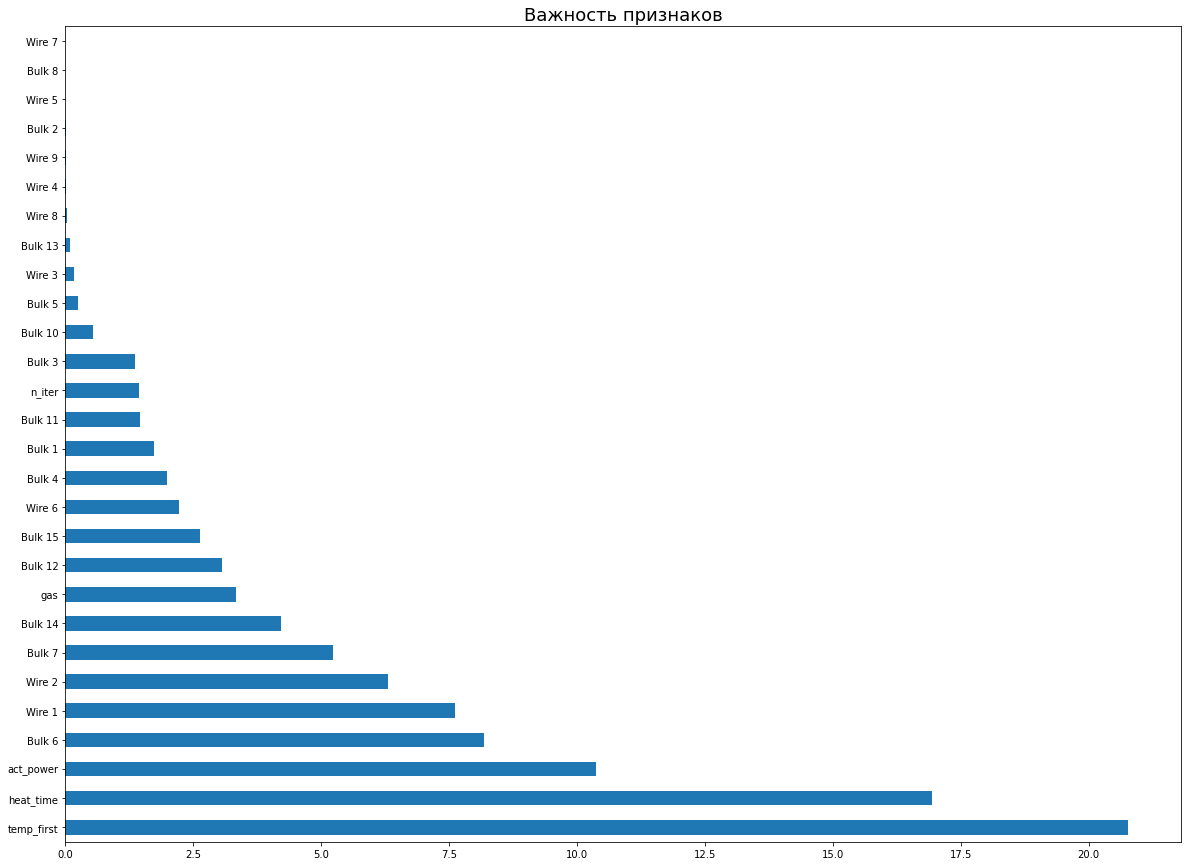

In [37]:
pd.Series(model_gb.feature_importances_, index=X_train.columns).nlargest(29).plot(kind='barh', figsize=(20,15))
plt.title('Важность признаков', fontsize=18)

Из графика видно, что достаточно большое количество признаков практически не влияют на целевой признак. Попробуем их удалить и заново построить модель градиентного бустинга.

In [38]:
X_dropped = X.drop(['Wire 7', 'Bulk 8', 'Wire 5', 'Bulk 2', 'Wire 9', 'Wire 4', 'Wire 8', 'Bulk 13',
                    'Wire 3', 'Bulk 5', 'Bulk 10'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
     X_dropped, y, test_size=0.25, random_state=1)

print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тест выборки:', X_test.shape, y_test.shape)

model_gb = CatBoostRegressor(loss_function='MAE',iterations=2000, grow_policy='Depthwise',
                             silent=True, min_data_in_leaf=150, depth=5, l2_leaf_reg=9, learning_rate=0.1)
#обучение
start_time = time.time()
model_gb.fit(X_train, y_train)
time_to_fit = time.time() - start_time
#предсказание
start_time = time.time()
predicted = model_gb.predict(X_test)
time_to_predict = time.time() - start_time

print('CatBoostRegressor')
print('MAE: {:.2f}'.format(mean_absolute_error(y_test,predicted)))
print('Время обучения: {:.3f}'.format(time_to_fit))
print('Время предсказания: {:.3f}\n'.format(time_to_predict))

Размер тренировочной выборки: (1674, 17) (1674,)
Размер тест выборки: (559, 17) (559,)
CatBoostRegressor
MAE: 5.63
Время обучения: 2.829
Время предсказания: 0.006



<a id='part2.6'></a>
## 2.6 Анализ моделей

Сведем все полученные результаты в таблицу.

||Линейная регрессия|Случайный лес|Метод опорных векторов|Градиентный бустинг|
|-|-|-|-|-|
| Время обучения, с |0.029|1.409|0.373|6.207|
| Время предсказания, с |0.002|0.022|0.056|0.016|
| МАЕ на тестовых данных |6.09|5.94|5.99|5.63|

Линейная регрессия имеет лучшее время обучения и наибольшее значение МАЕ.   
Лучшее значение МАЕ (5.63) достигнуто с помощью градиентного бустинга после удаления неважных признаков. Также градиентный бустинг дольше всего обучается (в 4 раза дольше, чем случайный лес, на котором также было достигнуто необходимое значение ошибки).

Стоит отметить, что разница в МАЕ линейной регрессией, методом опорных векторов и случайным лесом достаточно небольшая при очень большой разнице во времени обучения. Поэтому, если ошибка около 6 является удовлетворительной, то можно использовать модель линейной регрессии или опорных векторов, т.к. если данных будет больше, то разница во времени обучения станет заметной.

<a id='part3'></a>

##  Общий вывод

В результате работы были изучены и предобработаны данные об обработке стали.
Удалены пропуски, изменены типы данных, удалены ненужные признаки.
Добавлены новые признаки, все датафреймы сведены в один. После проверки на мультиколлинеарность один признак был удален.  

Было обучено и проанализировано несколько моделей (линейная регрессия, случайный лес, метод опорных векторов, градиентный бустинг) с целью найти оптимальную.
Самая точная и самая долгообучаемая модель - градиентный бустинг. Остальные модели обучаются значительно быстрее, но полученное значение МАЕ хуже.

Следовательно, если существует ограничение по времени обучения, то следует обратить внимание на метод опорных векторов или случайный лес.  
Если такого ограничения нет, то следует дальше улучшать градиентный бустинг.

Для градиентного бустинга был построен график важности признаков. По результатам его анализа было удалено 11 призанаков, не оказывающих влияния на целевую переменную. Значение МАЕ модели, обученной без этих признаков, получилось немного лучше, чем у первоначальной модели. (5.63 против 5.66)

Таким образом, можно сделать вывод, что следующие добавки не оказывают влияния на финальную температуру:

* Wire 3
* Wire 4
* Wire 5
* Wire 7 
* Wire 8
* Wire 9


* Bulk 2
* Bulk 5
* Bulk 8
* Bulk 10
* Bulk 13 

<a id='part4'></a>
# Отчет по решению


### Какие пункты плана были выполнены, а какие — нет (поясните почему)?  

После анализа данных был составлен следующий план работы

- [x]  Данные загружены
- [x]  Выполнена предобработка данных
    - [x]  Удалены пропуски и выбросы, изменены типы данных
    - [x]  Добавлены новые признаки
    - [x]  Все таблицы сведены в один общий датафрейм с призанками
    - [x]  Данные разделены на тренировочную и тестовую выборки
- [x]  Построена модель
    - [x]  Обучено несколько моделей
    - [x]  Выбраны лучшие гиперпараметры
    - [x]  Предсказано МАЕ
    - [x]  Модели проанализированы    
    - [x]  Выбрана лучшая модель    

Все пункты были выполнены.

### Какие трудности возникли и как вы их преодолели?  

Единственной возникшей трудностью стало то, что в плане не было учтено исследование проблемы мультколлинеарности и отсеивание неважных признаков. С помощью ревьюера данные проблемы были обозначены и решены. В результате 12 лишних признаков было удалено и качество моделей улучшилось.

### Какие ключевые шаги в решении задачи выделили?  

Ключевые шаги в решении данной задачи - это добавление новых признаков, удаление выбросов и выбор правильной модели.


### Какая ваша итоговая модель и какое у неё качество?  

Итоговая модель - градиентный бустинг c CatBoost. Итоговое значение МАЕ на тестовых данных - 5.63  
Также я бы обратил внимание на модель регрессии опорных векторов (SVR). Итоговое значение ошибки модели хуже (5.99), но все равно ниже требуемого. Зато эта модель обучается в 17 раз быстрее (0.164 с против 2.814 с).
